<a href="https://colab.research.google.com/github/budoorhza/PROJECT363/blob/main/good.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

# نسخ الملف إلى مساحة العمل
!cp '/content/drive/MyDrive/PROJECT363/BrainTumorDataset.zip' /content/

# فك الضغط في مساحة العمل
import shutil
zip_path = '/content/BrainTumorDataset.zip'
extract_path = '/content/BrainTumorDataset'
shutil.unpack_archive(zip_path, extract_path)

In [4]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [5]:
print("Files in extracted folder:", os.listdir(extract_path))

Files in extracted folder: ['Training', 'Testing']


In [6]:
def load_data(main_dir, img_size=(128, 128)):
    images, masks = [], []
    classes = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}  # تصنيفات الفئات
    for category in classes.keys():
        category_path = os.path.join(main_dir, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size)
            images.append(img)

            # إنشاء القناع
            mask = classes[category]
            masks.append(mask)

    images = np.array(images) / 255.0  # تطبيع الصور
    images = np.expand_dims(images, axis=-1)  # إضافة بُعد القناة
    masks = np.array(masks)  # تحويل الأقنعة إلى مصفوفة
    return images, masks

# مسارات المجلدات
training_dir = '/content/BrainTumorDataset/Training'
testing_dir = '/content/BrainTumorDataset/Testing'


# تحميل بيانات التدريب والاختبار
X_train, y_train = load_data(training_dir)
X_test, y_test = load_data(testing_dir)

#print("Original y_train shape:", y_train.shape)
#print("Original y_test shape:", y_test.shape)

# عرض الأشكال الأصلية للبيانات
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


# دالة لتحويل التصنيفات إلى أقنعة بكسلية
def create_pixel_masks(y, img_size=(128, 128), num_classes=4):
    masks = []
    for label in y:
        mask = np.zeros((img_size[0], img_size[1], num_classes))
        mask[..., int(label)] = 1  # تحويل الفئة إلى One-Hot
        masks.append(mask)
    return np.array(masks)

# إنشاء أقنعة بكسلية
y_train = create_pixel_masks(y_train, img_size=(128, 128), num_classes=4)
y_test = create_pixel_masks(y_test, img_size=(128, 128), num_classes=4)

# التأكد من الأشكال الجديدة
print("y_train shape after conversion:", y_train.shape)
print("y_test shape after conversion:", y_test.shape)

X_train shape: (5712, 128, 128, 1)
y_train shape: (5712,)
X_test shape: (1311, 128, 128, 1)
y_test shape: (1311,)
y_train shape after conversion: (5712, 128, 128, 4)
y_test shape after conversion: (1311, 128, 128, 4)


In [7]:
def unet_model(input_size=(128, 128, 1), num_classes=4):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv5)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 4)         │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 185,060 (722.89 KB)

 Trainable params: 185,060 (722.89 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# عرض القيم الدنيا والعليا للبيانات
print("X_train min, max:", X_train.min(), X_train.max())
print("y_train min, max:", y_train.min(), y_train.max())

X_train min, max: 0.0 1.0
y_train min, max: 0.0 1.0


In [10]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=16
)

Epoch 1/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.6024 - loss: 0.9270 - val_accuracy: 0.4948 - val_loss: 1.1876
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6083 - loss: 0.9113 - val_accuracy: 0.4350 - val_loss: 1.3012
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.6278 - loss: 0.8695 - val_accuracy: 0.6768 - val_loss: 0.9678
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.6399 - loss: 0.8460 - val_accuracy: 0.4376 - val_loss: 1.3336
Epoch 5/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6473 - loss: 0.8253 - val_accuracy: 0.8146 - val_loss: 0.6493
Epoch 6/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6559 - loss: 0.8107 - val_accuracy: 0.3733 - val_loss: 1.4730
Epoch 7/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.6609 - loss: 0.8012 - val_accuracy: 0.6679 - val_loss: 0.8913
Epoch 8/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6737 - loss: 0.7718 - val_

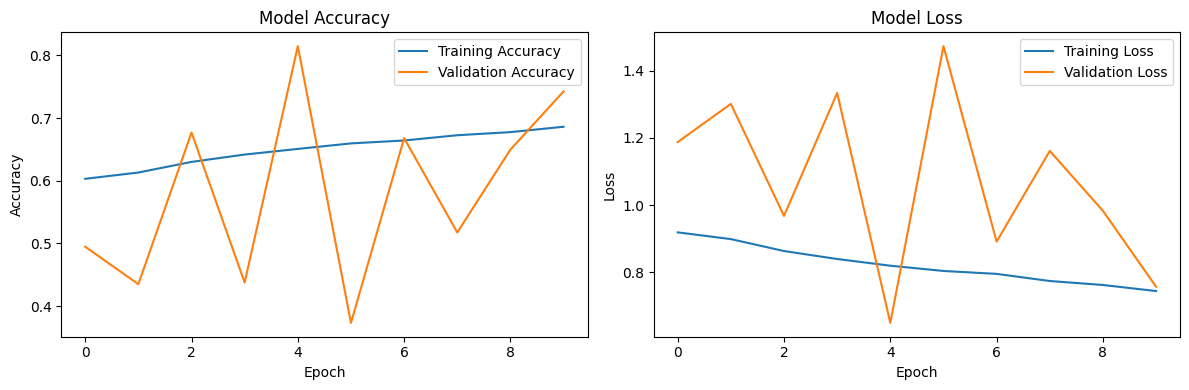

In [11]:
# رسم منحنيات التدريب
plt.figure(figsize=(12, 4))

# دقة النموذج
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# خسارة النموذج
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
#print("Original y_train shape:", y_train.shape)

Original y_train shape: (5712, 128, 128, 4)


In [8]:
# تحويل y_train و y_test إلى أقنعة لكل بكسل
def create_pixel_masks(y, img_size=(128, 128), num_classes=4):
    masks = []
    for label in y:
        # إنشاء قناع لكل تصنيف بحجم الصورة
        mask = np.full((img_size[0], img_size[1], num_classes), label.argmax(), dtype=np.float32)
        masks.append(mask)
    return np.array(masks)

# إنشاء أقنعة بكسلية
y_train = create_pixel_masks(y_train, img_size=(128, 128), num_classes=4)
y_test = create_pixel_masks(y_test, img_size=(128, 128), num_classes=4)

# التأكد من الأشكال
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5712, 128, 128, 1)
y_train shape: (5712, 128, 128, 4)
X_test shape: (1311, 128, 128, 1)
y_test shape: (1311, 128, 128, 4)


In [10]:
print("X_train min, max:", X_train.min(), X_train.max())
print("y_train min, max:", y_train.min(), y_train.max())

X_train min, max: 0.0 1.0
y_train min, max: 0.0 3.0


In [11]:
print("Unique values in y_train:", np.unique(y_train))
print("Unique values in y_test:", np.unique(y_test))

Unique values in y_train: [0. 1. 2. 3.]
Unique values in y_test: [0. 1. 2. 3.]


In [12]:

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (5712, 128, 128, 1)
y_train shape: (5712, 128, 128, 4)


In [13]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Unique values in y_train:", np.unique(y_train))


X_train shape: (5712, 128, 128, 1)
y_train shape: (5712, 128, 128, 4)
Unique values in y_train: [0. 1. 2. 3.]


In [15]:

# تحويل y_train و y_test إلى تصنيفات رقمية
y_train = np.argmax(y_train, axis=-1)
y_test = np.argmax(y_test, axis=-1)

# التأكد من الأشكال الجديدة
print("New y_train shape:", y_train.shape)  # يجب أن يكون (5712, 128, 128)
print("New y_test shape:", y_test.shape)    # يجب أن يكون (عدد الصور, 128, 128)

# إعداد النموذج باستخدام sparse_categorical_crossentropy
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# تدريب النموذج
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=16
)

New y_train shape: (5712, 128, 128)
New y_test shape: (1311, 128, 128)
Epoch 1/5
322/322 ━━━━━━━━━━━━━━━━━━━━ 48s 102ms/step - accuracy: 0.9873 - loss: 0.0700 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/5
322/322 ━━━━━━━━━━━━━━━━━━━━ 53s 55ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/5
322/322 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
322/322 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/5
322/322 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


In [16]:

print("Are training and testing data identical?", np.array_equal(X_train, X_test))

Are training and testing data identical? False


In [17]:

print("Unique classes in y_train:", np.unique(y_train))
print("Unique classes in y_test:", np.unique(y_test))

Unique classes in y_train: [0]
Unique classes in y_test: [0]


In [ ]:
def unet_model(input_size=(128, 128, 1), num_classes=4):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up5)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv5)

    model = Model(inputs, outputs)
    #model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])




    return model

model = unet_model()
model.summary()